In [58]:
import os, sys
import pandas as pd
import numpy as np
import pickle

from scipy.stats import ttest_ind

import numpy as np

import seaborn as sns

from skimage import io
from skimage.filters import gaussian

from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option("display.max_rows",999)
pd.set_option('display.max_columns',999)

In [3]:
def unpickle(file):
    with open(file, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        dict = u.load()

    return(dict)

# Load Data

In [9]:
labels = []
data = []
for i in range(5):
    readData = unpickle('data/cifar/data_batch_{}'.format(i+1))
    labels.append(readData['labels'])
    data.append(readData['data'])

labels = pd.DataFrame(labels[0] + labels[1] + labels[2] + labels[3] + labels[4], columns = ['labels']).query('(labels == 0) | (labels == 1) | (labels == 2) | (labels == 3)')
images = pd.DataFrame(np.vstack(data)).iloc[labels.index]
labels = labels.reset_index(drop=True)
images = images.reset_index(drop=True)

In [10]:
labels['labels'].value_counts()

3    5000
2    5000
1    5000
0    5000
Name: labels, dtype: int64

In [12]:
images = scale(images, axis=1)

# Kfold Function

In [56]:
class kFold:
    def __init__(self, cv):
        self._cv = cv
        self.variables = None
        self.yVars = None
        self.mClassifier = None
        self._metrics = None
        
    @property
    def cv():
        return self._cv
    
    @property
    def metrics():
        return self._metrics
    
    def fit(self, variables, yVars, mClassifier, verbose=False, plot=True):
        self.variables = variables
        self.yVars = yVars
        self.mClassifier = mClassifier
        
        self._metrics = {
            'accuracy': [],
            'precision': [],
            'recall': []
        }

        kf = KFold(n_splits = self._cv)

        for train_index, test_index in kf.split(self.variables):
            xTrain, xTest = variables.iloc[train_index], variables.iloc[test_index]
            yTrain, yTest = yVars.iloc[train_index], yVars.iloc[test_index]

            self.mClassifier.fit(xTrain, yTrain)
            mPredict = self.mClassifier.predict(xTest)

            if verbose == True:
                print('Accuracy', '.'*5, accuracy_score(yTest, mPredict), '\n')
                print('Classification Report', '.'*5, '\n')
                print(classification_report(yTest, mPredict))
                print('Confusion Matrix', '.'*5, '\n')
                print(pd.DataFrame(confusion_matrix(yTest, mPredict)), '\n\n\n')
            self._metrics['accuracy'].append(accuracy_score(yTest, mPredict))
            self._metrics['precision'].append(precision_score(yTest, mPredict, average='weighted'))
            self._metrics['recall'].append(recall_score(yTest, mPredict, average='weighted'))

#         metrics = pd.DataFrame([accuracy,precision,recall]).T
#         metrics.columns = ['accuracy','precision','recall']
        if plot == True:
            plt.figure()
            plt.title(f"Accuracy: Mean {round(np.average(self._metrics['accuracy']), 4)} | SD {round(np.std(self._metrics['accuracy']), 4)}")
            sns.boxplot(pd.DataFrame(self._metrics))

In [13]:
def kfoldFunction(variables, yVars, mClassifier, cv = 5, verbose = False, plot = False):
    accuracy = []
    precision = []
    recall = []
    kf = KFold(n_splits = cv)

    for train_index, test_index in kf.split(variables):
        xTrain, xTest = variables.iloc[train_index], variables.iloc[test_index]
        yTrain, yTest = yVars.iloc[train_index], yVars.iloc[test_index]

        mClassifier = mClassifier.fit(xTrain, yTrain)
        mPredict = mClassifier.predict(xTest)

        if verbose == True:
            print('Accuracy:', accuracy_score(yTest, mPredict), '\n')
            print(classification_report(yTest, mPredict))
            print(pd.DataFrame(confusion_matrix(yTest, mPredict)), '\n\n\n')
        accuracy.append(accuracy_score(yTest, mPredict))
        precision.append(precision_score(yTest, mPredict, average='weighted'))
        recall.append(recall_score(yTest, mPredict, average='weighted'))
    
    metrics = pd.DataFrame([accuracy,precision,recall]).T
    metrics.columns = ['accuracy','precision','recall']
    if plot == True:
        plt.figure()
        plt.title('Accuracy: Mean {} | SD {}'.format(round(np.average(accuracy),4), round(np.std(accuracy),4)))

        sns.boxplot(metrics)
    return(metrics)

## Sample

In [15]:
imagesSamp, imagesSamp2, labelsSamp, labelsSamp2 = train_test_split(images, labels, test_size=0.75)

# Feature Extraction

## Regular Pixels

### PCA

In [16]:
pca = PCA(n_components=50)
pca.fit(imagesSamp)
imagesTrans = pca.fit_transform(imagesSamp)

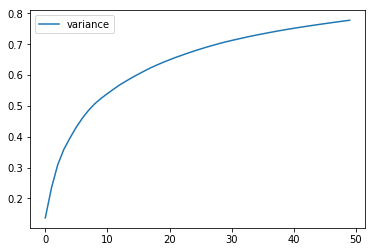

In [17]:
pd.DataFrame(pca.explained_variance_ratio_.cumsum(), columns = ['variance']).plot()

In [ ]:
### Kernal PCA Sigmoid

kpca = KernelPCA(n_components=50, kernel='sigmoid', n_jobs=-1)
kpca.fit(np.array(imagesSamp))
kSigImageTrans = kpca.fit_transform(imagesSamp)

### Kernal PCA Linear

kpca = KernelPCA(n_components=50, kernel='linear', n_jobs=-1)
kpca.fit(np.array(imagesSamp))
kLinImageTrans = kpca.fit_transform(imagesSamp)

### Kernal PCA poly

kpca = KernelPCA(n_components=50, kernel='poly', n_jobs=-1)
kpca.fit(np.array(imagesSamp))
kPolyImageTrans = kpca.fit_transform(imagesSamp)

### Kernal PCA Cosine

kpca = KernelPCA(n_components=50, kernel='cosine', n_jobs=-1)
kpca.fit(np.array(imagesSamp))
kCosImageTrans = kpca.fit_transform(imagesSamp)

## Gaussian Blur Filter

In [22]:
imagesGBlur = imagesSamp
for i in range(len(imagesSamp)):
    blurredImage = gaussian(imagesSamp[i].reshape((3,1024)).swapaxes(0,1).reshape((32, 32, 3)), sigma=.5, multichannel=True)
    imagesGBlur[i] = blurredImage.reshape(-1)

### PCA

In [23]:
pca = PCA(n_components=15)
pca.fit(imagesGBlur)
imagesTransG = pca.fit_transform(imagesSamp)

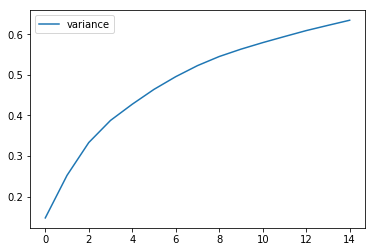

In [24]:
pd.DataFrame(pca.explained_variance_ratio_.cumsum(), columns = ['variance']).plot()

In [59]:
### Kernal PCA Sigmoid

kpca = KernelPCA(n_components=15, kernel='sigmoid', n_jobs=-1)
kpca.fit(np.array(imagesGBlur))
kSigImageTransG = kpca.fit_transform(imagesGBlur)

### Kernal PCA Linear

kpca = KernelPCA(n_components=15, kernel='linear', n_jobs=-1)
kpca.fit(np.array(imagesGBlur))
kLinImageTransG = kpca.fit_transform(imagesGBlur)

### Kernal PCA poly

kpca = KernelPCA(n_components=15, kernel='poly', n_jobs=-1)
kpca.fit(np.array(imagesGBlur))
kPolyImageTransG = kpca.fit_transform(imagesGBlur)

### Kernal PCA Cosine

kpca = KernelPCA(n_components=15, kernel='cosine', n_jobs=-1)
kpca.fit(np.array(imagesGBlur))
kCosImageTransG = kpca.fit_transform(imagesGBlur)

# Modeling

## Parameter Selection: Raw Pixel Data

### rbf

In [29]:
dataDict = {
    'PCA': imagesTrans, 
    'Sigmoid PCA': kSigImageTrans,
    'Linear PCA': kLinImageTrans, 
    'Poly PCA': kPolyImageTrans, 
    'Cosine PCA': kCosImageTrans
}

In [30]:
for data in dataDict:
    param_grid = {
        'C': [1, 100, 1e3, 1e5],
        'gamma': [0.0001, 0.0005, 0.001]
    }

    clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=-1)
    clf = clf.fit(pd.DataFrame(dataDict[data]), labelsSamp['labels'])
    print('\n', data)
    print('best score: ', clf.best_score_)
    print(clf.best_estimator_)


 PCA
best score:  0.6848
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Sigmoid PCA
best score:  0.6018
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Linear PCA
best score:  0.6846
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Poly PCA
best score:  0.6652
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_st

### sigmoid

In [31]:
for data in dataDict:
    param_grid = {
        'C': [1, 100, 1e3, 1e5],
        'gamma': [0.0001, 0.0005, 0.001],
        'coef0': [0, 1, 10]
    }

    clf = GridSearchCV(svm.SVC(kernel='sigmoid', class_weight='balanced'), param_grid, n_jobs=-1)
    clf = clf.fit(pd.DataFrame(dataDict[data]), labelsSamp['labels'])
    print('\n', data)
    print('best score: ', clf.best_score_)
    print(clf.best_estimator_)


 PCA
best score:  0.5956
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Sigmoid PCA
best score:  0.5906
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Linear PCA
best score:  0.5966
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)



KeyboardInterrupt



### poly

In [32]:
for data in dataDict:
    param_grid = {
        'C': [1, 100, 1e3],
        'gamma': [0.0001, 0.0005, 0.001],
        'coef0': [0, 0.5, 1],
        'degree': [3, 4, 5]
    }

    clf = GridSearchCV(svm.SVC(kernel='poly', class_weight='balanced'), param_grid, n_jobs=-1)
    clf = clf.fit(pd.DataFrame(dataDict[data]), labelsSamp['labels'])
    print('\n', data)
    print('best score: ', clf.best_score_)
    print(clf.best_estimator_)


 PCA
best score:  0.6728
SVC(C=1, cache_size=200, class_weight='balanced', coef0=1,
  decision_function_shape=None, degree=5, gamma=0.0001, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Sigmoid PCA
best score:  0.5828
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=1,
  decision_function_shape=None, degree=4, gamma=0.001, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Linear PCA
best score:  0.6716
SVC(C=1, cache_size=200, class_weight='balanced', coef0=1,
  decision_function_shape=None, degree=5, gamma=0.0001, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Poly PCA
best score:  0.6388
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=1,
  decision_function_shape=None, degree=5, gamma=0.001, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shri

## Parameter Selection: Gaussian Blur Data

### rbf

In [33]:
dataDict = {'imagesTransG': imagesTransG, 'kSigImageTransG': kSigImageTransG, 'kLinImageTransG': kLinImageTransG, 'kPolyImageTransG': kPolyImageTransG, 'kCosImageTransG': kCosImageTransG}

In [34]:
for data in dataDict:
    param_grid = {
        'C': [1, 100, 1e3, 1e5],
        'gamma': [0.0001, 0.0005, 0.001]
    }

    clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=-1)
    clf = clf.fit(pd.DataFrame(dataDict[data]), labelsSamp['labels'])
    print('\n', data)
    print('best score: ', clf.best_score_)
    print(clf.best_estimator_)


 imagesTransG
best score:  0.6384
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kSigImageTransG
best score:  0.5788
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kLinImageTransG
best score:  0.6386
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kPolyImageTransG
best score:  0.616
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability

### sigmoid

In [35]:
for data in dataDict:
    param_grid = {
        'C': [1, 100, 1e3, 1e5],
        'gamma': [0.0001, 0.0005, 0.001],
        'coef0': [0, 1, 10]
    }

    clf = GridSearchCV(svm.SVC(kernel='sigmoid', class_weight='balanced'), param_grid, n_jobs=-1)
    clf = clf.fit(pd.DataFrame(dataDict[data]), labelsSamp['labels'])
    print('\n', data)
    print('best score: ', clf.best_score_)
    print(clf.best_estimator_)


 imagesTransG
best score:  0.5666
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kSigImageTransG
best score:  0.568
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape=None, degree=3, gamma=0.0005, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kLinImageTransG
best score:  0.5666
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kPolyImageTransG
best score:  0.5728
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape=None, degree=3, gamma=0.0005, kernel='sigmoid',
  max_iter=-1, p

### poly

In [36]:
for data in dataDict:
    param_grid = {
        'C': [1, 100, 1e3, 1e5],
        'gamma': [0.0001, 0.0005, 0.001],
        'coef0': [0, 0.5, 1],
        'degree': [3, 4, 5]
    }

    clf = GridSearchCV(svm.SVC(kernel='poly', class_weight='balanced'), param_grid, n_jobs=-1)
    clf = clf.fit(pd.DataFrame(dataDict[data]), labelsSamp['labels'])
    print('\n', data)
    print('best score: ', clf.best_score_)
    print(clf.best_estimator_)


 imagesTransG
best score:  0.639
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.5,
  decision_function_shape=None, degree=5, gamma=0.0005, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kSigImageTransG
best score:  0.599
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=1,
  decision_function_shape=None, degree=5, gamma=0.001, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kLinImageTransG
best score:  0.639
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.5,
  decision_function_shape=None, degree=5, gamma=0.0005, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 kPolyImageTransG
best score:  0.6208
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=1,
  decision_function_shape=None, degree=5, gamma=0.001, kernel='poly',
  max_iter=-1, probability

## Modeling on PCA

#### Student's t-Test

In [39]:
def metricsTest(data):
    for i in range(4):
        for j in range(i+1, 5):
            print(ttest_ind(data[i]['accuracy'], data[j]['accuracy'], equal_var=False), (ttest_ind(data[0]['accuracy'], data[1]['accuracy'], equal_var=False).pvalue < 0.05))

### rbf SVM

In [40]:
rbfMetrics = []
kernel = 'rbf'
clf = {
    'imagesTrans': [svm.SVC(C=1, class_weight='balanced', gamma=0.001, kernel=kernel), imagesTrans], 
    'kSigImageTrans' : [svm.SVC(C=100000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kSigImageTrans], 
    'kLinImageTrans' : [svm.SVC(C=100.0, class_weight='balanced', gamma=0.001, kernel=kernel), kLinImageTrans], 
    'kPolyImageTrans' : [svm.SVC(C=10000.0, class_weight='balanced', gamma=0.0005, kernel=kernel), kPolyImageTrans], 
    'kCosImageTrans' : [svm.SVC(C=10000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kCosImageTrans]
}

In [41]:
for i in clf:
    rbfMetrics.append(kfoldFunction(pd.DataFrame(clf[i][1]), labelsSamp['labels'], clf[i][0], cv=10))
metricsTest(rbfMetrics)

Ttest_indResult(statistic=8.15525406031061, pvalue=2.2313760523468895e-07) True
Ttest_indResult(statistic=0.1731018203461796, pvalue=0.8645076476632885) True
Ttest_indResult(statistic=5.573920380674981, pvalue=4.414746963312056e-05) True
Ttest_indResult(statistic=10.22046571346862, pvalue=3.707427082553462e-08) True
Ttest_indResult(statistic=-7.736573889634557, pvalue=5.192206255954535e-07) True
Ttest_indResult(statistic=-3.6731121415016124, pvalue=0.0018691032241670796) True
Ttest_indResult(statistic=1.245254622539186, pvalue=0.2304954190992003) True
Ttest_indResult(statistic=5.185373609214695, pvalue=0.00010318559890207596) True
Ttest_indResult(statistic=9.654282158277029, pvalue=1.0135433883802697e-07) True
Ttest_indResult(statistic=5.7898612053786485, pvalue=1.78736133363577e-05) True


CHOICE:
'PCA': 

### Sigmoid SVM

In [158]:
sigMetrics = []
kernel = 'sigmoid'
clf = {'imagesTrans': [svm.SVC(C=1, class_weight='balanced', gamma=0.0001, kernel=kernel), imagesTrans], 
       'kSigImageTrans' : [svm.SVC(C=100000.0, class_weight='balanced', gamma=0.0001, kernel=kernel), kSigImageTrans], 
       'kLinImageTrans' : [svm.SVC(C=1.0, class_weight='balanced', gamma=0.0001, kernel=kernel), kLinImageTrans], 
       'kPolyImageTrans' : [svm.SVC(C=1000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kPolyImageTrans], 
       'kCosImageTrans' : [svm.SVC(C=1000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kCosImageTrans]}

In [159]:
for i in clf:
    sigMetrics.append(kfoldFunction(pd.DataFrame(clf[i][1]), labelsSamp['labels'], clf[i][0], cv=10))
metricsTest(sigMetrics)

Ttest_indResult(statistic=0.99057926200437318, pvalue=0.33569654991740272) False
Ttest_indResult(statistic=0.023180714250519745, pvalue=0.9817619656904254) False
Ttest_indResult(statistic=-4.8121892961197013, pvalue=0.0001429113947144117) True
Ttest_indResult(statistic=-0.70210949749940954, pvalue=0.49197870027196222) False


Ttest_indResult(statistic=-0.99132165922233473, pvalue=0.3356907261894343) False
Ttest_indResult(statistic=-5.2072217455807621, pvalue=8.0282386726395808e-05) True
Ttest_indResult(statistic=-1.5347806131561075, pvalue=0.14223496159870719) False


Ttest_indResult(statistic=-4.9829025605747068, pvalue=9.6736167099014181e-05) True
Ttest_indResult(statistic=-0.73785916432465204, pvalue=0.47075633374707659) False


Ttest_indResult(statistic=3.511279044940788, pvalue=0.0027724315200083607) True


CHOICE:
'Poly PCA': 

### Poly SVM

In [160]:
polyMetrics = []
kernel = 'poly'
clf = {'imagesTrans': [svm.SVC(C=1, degree=5, class_weight='balanced', gamma=0.0001, coef0=1, kernel=kernel), imagesTrans], 
       'kSigImageTrans' : [svm.SVC(C=1000.0, degree=4, class_weight='balanced', gamma=0.001, coef0=1, kernel=kernel), kSigImageTrans], 
       'kLinImageTrans' : [svm.SVC(C=1.0, degree=5, class_weight='balanced', gamma=0.0001, coef0=1, kernel=kernel), kLinImageTrans], 
       'kPolyImageTrans' : [svm.SVC(C=1000.0, degree=5, class_weight='balanced', gamma=0.001, coef0=1, kernel=kernel), kPolyImageTrans], 
       'kCosImageTrans' : [svm.SVC(C=1000.0, degree=5, class_weight='balanced', gamma=0.001, coef0=1, kernel=kernel), kCosImageTrans]}

In [161]:
for i in clf:
    polyMetrics.append(kfoldFunction(pd.DataFrame(clf[i][1]), labelsSamp['labels'], clf[i][0], cv=10))
metricsTest(polyMetrics)

Ttest_indResult(statistic=10.464407243285402, pvalue=2.7811663762096278e-08) True
Ttest_indResult(statistic=-0.50734340249520649, pvalue=0.61822199446822879) False
Ttest_indResult(statistic=5.9207335610785377, pvalue=1.3471446784639259e-05) True
Ttest_indResult(statistic=8.3270479475283352, pvalue=3.4375459502596144e-07) True


Ttest_indResult(statistic=-11.240541279108344, pvalue=2.8177871179532214e-08) True
Ttest_indResult(statistic=-6.3023693727560222, pvalue=1.6941523889517752e-05) True
Ttest_indResult(statistic=-2.3717252599748209, pvalue=0.029190295428033631) True


Ttest_indResult(statistic=6.922319404814762, pvalue=1.8946538327855412e-06) True
Ttest_indResult(statistic=9.1035007349083745, pvalue=2.2321231466327442e-07) True


Ttest_indResult(statistic=3.8141869329339095, pvalue=0.0016320710754051358) True


CHOICE:
'PCA': 

## Modeling on PCA: Gaussian Blur

### rbf SVM

In [162]:
rbfMetricsG = []
kernel = 'rbf'
clf = {'imagesTransG': [svm.SVC(C=1, class_weight='balanced', gamma=0.001, kernel=kernel), imagesTransG], 
       'kSigImageTransG' : [svm.SVC(C=100000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kSigImageTransG], 
       'kLinImageTransG' : [svm.SVC(C=1.0, class_weight='balanced', gamma=0.001, kernel=kernel), kLinImageTransG], 
       'kPolyImageTransG' : [svm.SVC(C=100000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kPolyImageTransG], 
       'kCosImageTransG' : [svm.SVC(C=100000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kCosImageTransG]}

In [163]:
for i in clf:
    rbfMetricsG.append(kfoldFunction(pd.DataFrame(clf[i][1]), labelsSamp['labels'], clf[i][0], cv=10))
metricsTest(rbfMetricsG)

Ttest_indResult(statistic=7.4400610568496646, pvalue=7.1286573898857957e-07) True
Ttest_indResult(statistic=0.0, pvalue=1.0) False
Ttest_indResult(statistic=3.3687377135038896, pvalue=0.0034271508828844122) True
Ttest_indResult(statistic=1.8762057121506877, pvalue=0.077018752307887156) False


Ttest_indResult(statistic=-7.4400610568496646, pvalue=7.1286573898857957e-07) True
Ttest_indResult(statistic=-4.0887209557832431, pvalue=0.00069210313094316127) True
Ttest_indResult(statistic=-5.200225831731367, pvalue=6.5240143021347131e-05) True


Ttest_indResult(statistic=3.3687377135038896, pvalue=0.0034271508828844122) True
Ttest_indResult(statistic=1.8762057121506877, pvalue=0.077018752307887156) False


Ttest_indResult(statistic=-1.3308966138118132, pvalue=0.20004368517980417) False


CHOICE:
'PCA': 

### Sigmoid SVM

In [164]:
sigMetricsG = []
kernel = 'sigmoid'
clf = {'imagesTransG': [svm.SVC(C=1, class_weight='balanced', gamma=0.0001, kernel=kernel), imagesTransG], 
       'kSigImageTransG' : [svm.SVC(C=100000.0, class_weight='balanced', gamma=0.0001, kernel=kernel), kSigImageTransG], 
       'kLinImageTransG' : [svm.SVC(C=1.0, class_weight='balanced', gamma=0.0001, kernel=kernel), kLinImageTransG], 
       'kPolyImageTransG' : [svm.SVC(C=1000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kPolyImageTransG], 
       'kCosImageTransG' : [svm.SVC(C=1000.0, class_weight='balanced', gamma=0.001, kernel=kernel), kCosImageTransG]}

In [165]:
for i in clf:
    sigMetricsG.append(kfoldFunction(pd.DataFrame(clf[i][1]), labelsSamp['labels'], clf[i][0], cv=10))
metricsTest(sigMetricsG)

Ttest_indResult(statistic=0.29773257907841955, pvalue=0.76940265427983334) False
Ttest_indResult(statistic=0.0, pvalue=1.0) False
Ttest_indResult(statistic=-0.51162358351286097, pvalue=0.61531739632598437) False
Ttest_indResult(statistic=-0.74530487594859085, pvalue=0.46651961641653883) False


Ttest_indResult(statistic=-0.29773257907841955, pvalue=0.76940265427983334) False
Ttest_indResult(statistic=-0.78068889511261297, pvalue=0.44617972990586474) False
Ttest_indResult(statistic=-0.95625061107832476, pvalue=0.35185416185895346) False


Ttest_indResult(statistic=-0.51162358351286097, pvalue=0.61531739632598437) False
Ttest_indResult(statistic=-0.74530487594859085, pvalue=0.46651961641653883) False


Ttest_indResult(statistic=-0.36748909032957244, pvalue=0.71836987224353188) False


CHOICE:
'PCA': 

### Poly SVM

In [166]:
polyMetricsG = []
kernel = 'poly'
clf = {'imagesTransG': [svm.SVC(C=1, degree=5, class_weight='balanced', gamma=0.0005, coef0=.5, kernel=kernel), imagesTransG], 
       'kSigImageTransG' : [svm.SVC(C=100000.0, degree=5, class_weight='balanced', gamma=0.001, coef0=1, kernel=kernel), kSigImageTransG], 
       'kLinImageTransG' : [svm.SVC(C=1.0, degree=5, class_weight='balanced', gamma=0.0005, coef0=.5, kernel=kernel), kLinImageTransG], 
       'kPolyImageTransG' : [svm.SVC(C=100000.0, degree=5, class_weight='balanced', gamma=0.001, coef0=1, kernel=kernel), kPolyImageTransG], 
       'kCosImageTransG' : [svm.SVC(C=100000.0, degree=5, class_weight='balanced', gamma=0.001, coef0=1, kernel=kernel), kCosImageTransG]}

In [167]:
for i in clf:
    polyMetricsG.append(kfoldFunction(pd.DataFrame(clf[i][1]), labelsSamp['labels'], clf[i][0], cv=10))
metricsTest(polyMetricsG)

Ttest_indResult(statistic=5.1188827852417678, pvalue=7.1923816898350582e-05) True
Ttest_indResult(statistic=0.0, pvalue=1.0) False
Ttest_indResult(statistic=2.2052416634541951, pvalue=0.040910701843451754) True
Ttest_indResult(statistic=0.8527353204624778, pvalue=0.40626607795009517) False


Ttest_indResult(statistic=-5.1188827852417678, pvalue=7.1923816898350582e-05) True
Ttest_indResult(statistic=-2.5461424301246662, pvalue=0.020493700483828533) True
Ttest_indResult(statistic=-3.2943677852356381, pvalue=0.0045792641465507633) True


Ttest_indResult(statistic=2.2052416634541951, pvalue=0.040910701843451754) True
Ttest_indResult(statistic=0.8527353204624778, pvalue=0.40626607795009517) False


Ttest_indResult(statistic=-1.0219244035981063, pvalue=0.32098805771474892) False


CHOICE:
'PCA': 

### Raw Pixels

In [168]:
print(ttest_ind(rbfMetrics[0]['accuracy'], sigMetrics[4]['accuracy']))
print(ttest_ind(rbfMetrics[0]['accuracy'], polyMetrics[0]['accuracy']))
print('\n')
print(ttest_ind(sigMetrics[4]['accuracy'], polyMetrics[0]['accuracy']))

Ttest_indResult(statistic=9.2463822063437284, pvalue=2.9407046369719017e-08)
Ttest_indResult(statistic=0.34605541471153378, pvalue=0.73331301071331534)


Ttest_indResult(statistic=-9.2063024248945329, pvalue=3.1388753942274763e-08)


CHOICE: 'rbf SVM: PCA'

### Gaussian Blur Pixels

In [169]:
print(ttest_ind(rbfMetricsG[0]['accuracy'], sigMetricsG[0]['accuracy']))
print(ttest_ind(rbfMetricsG[0]['accuracy'], polyMetricsG[0]['accuracy']))
print('\n')
print(ttest_ind(sigMetricsG[0]['accuracy'], polyMetricsG[0]['accuracy']))

Ttest_indResult(statistic=9.1660865617308591, pvalue=3.3517842608840459e-08)
Ttest_indResult(statistic=0.40648639297028777, pvalue=0.68917747905820514)


Ttest_indResult(statistic=-9.5399430777667718, pvalue=1.8344116347262663e-08)


CHOICE: 'rbf SVM: PCA'

### Raw vs Gaussian

In [170]:
print(ttest_ind(rbfMetrics[0]['accuracy'], rbfMetricsG[0]['accuracy']))

Ttest_indResult(statistic=4.7504742327547742, pvalue=0.00015978438169250256)


CHOICE: 'rbf SVM: PCA'

# Final Model

In [14]:
pca = PCA(n_components=50)
pca.fit(images)
imagesTrans = pca.fit_transform(images)

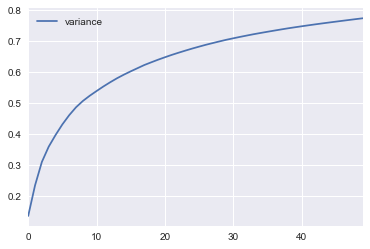

In [15]:
pd.DataFrame(pca.explained_variance_ratio_.cumsum(), columns = ['variance']).plot()

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.757 

             precision    recall  f1-score   support

          0       0.80      0.77      0.78       514
          1       0.80      0.83      0.81       465
          2       0.72      0.66      0.69       524
          3       0.71      0.78      0.74       497

avg / total       0.76      0.76      0.76      2000

     0    1    2    3
0  394   45   44   31
1   28  388   20   29
2   56   24  346   98
3   12   31   68  386 



Accuracy: 0.7525 

             precision    recall  f1-score   support

          0       0.77      0.80      0.79       486
          1       0.81      0.79      0.80       502
          2       0.73      0.66      0.69       501
          3       0.70      0.76      0.73       511

avg / total       0.75      0.75      0.75      2000

     0    1    2    3
0  390   40   32   24
1   48  398   18   38
2   50   20  329  102
3   19   33   71  388 



Accuracy: 0.734 

             precision    recall  f1-score   support

          0       0.7

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


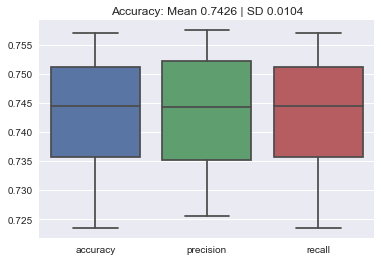

In [203]:
clf = svm.SVC(C=1, class_weight='balanced', gamma=0.001)
rbfMetrics = kfoldFunction(pd.DataFrame(imagesTrans), labels, clf, cv=10, plot=True, verbose=True)

/Users/lukasz.filipek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy ..... 0.244 

Classification Report ..... 

             precision    recall  f1-score   support

          0       0.23      0.20      0.21       254
          1       0.22      0.13      0.16       244
          2       0.28      0.34      0.31       256
          3       0.24      0.30      0.26       246

avg / total       0.24      0.24      0.24      1000

Confusion Matrix ..... 

    0   1   2   3
0  52  44  81  77
1  65  31  67  81
2  52  38  88  78
3  62  31  80  73 





/Users/lukasz.filipek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy ..... 0.24 

Classification Report ..... 

             precision    recall  f1-score   support

          0       0.23      0.19      0.21       260
          1       0.18      0.20      0.19       221
          2       0.29      0.25      0.27       268
          3       0.26      0.32      0.28       251

avg / total       0.24      0.24      0.24      1000

Confusion Matrix ..... 

    0   1   2   3
0  49  78  57  76
1  50  44  55  72
2  54  63  67  84
3  57  65  49  80 





/Users/lukasz.filipek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy ..... 0.229 

Classification Report ..... 

             precision    recall  f1-score   support

          0       0.19      0.27      0.23       233
          1       0.17      0.11      0.13       253
          2       0.24      0.29      0.26       245
          3       0.30      0.25      0.28       269

avg / total       0.23      0.23      0.22      1000

Confusion Matrix ..... 

    0   1   2   3
0  64  37  73  59
1  92  27  85  49
2  80  48  70  47
3  95  45  61  68 





/Users/lukasz.filipek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy ..... 0.243 

Classification Report ..... 

             precision    recall  f1-score   support

          0       0.26      0.27      0.27       253
          1       0.20      0.14      0.17       249
          2       0.25      0.27      0.26       256
          3       0.24      0.29      0.26       242

avg / total       0.24      0.24      0.24      1000

Confusion Matrix ..... 

    0   1   2   3
0  69  46  59  79
1  73  35  79  62
2  54  48  68  86
3  66  42  63  71 





/Users/lukasz.filipek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy ..... 0.244 

Classification Report ..... 

             precision    recall  f1-score   support

          0       0.27      0.24      0.25       259
          1       0.26      0.15      0.19       249
          2       0.23      0.33      0.27       234
          3       0.24      0.27      0.25       258

avg / total       0.25      0.24      0.24      1000

Confusion Matrix ..... 

    0   1   2   3
0  61  35  91  72
1  52  37  86  74
2  43  37  77  77
3  71  33  85  69 





/Users/lukasz.filipek/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


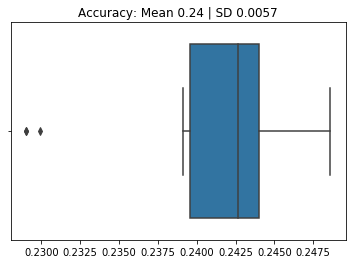

In [57]:
rfc = RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=20, n_jobs=-1)
kf = kFold(cv=5)
kf.fit(pd.DataFrame(imagesTrans), labels, rfc, plot=True, verbose=True)
# rfcMetrics = kfoldFunction(pd.DataFrame(imagesTrans), labels, rfc, cv=10, plot=True, verbose=True)

# Analyzing Birds

## Bird

In [206]:
imagesTrans = pd.DataFrame(imagesTrans)

In [275]:
bird = labels.query('labels == 2')
birdImages = imagesTrans.iloc[bird.index]

In [276]:
birdImagesMean = birdImages.mean(axis=0)

In [277]:
birdImagesMean.sort_values(ascending=False).head()

0     2.980220
13    2.782213
4     1.928870
11    1.043678
1     0.972945
dtype: float64

## Cat and Airplane

In [278]:
plane = labels.query('labels == 0')
planeImages = imagesTrans.iloc[plane.index]

In [279]:
planeImagesMean = planeImages.mean(axis=0)

In [280]:
planeImagesMean.sort_values(ascending=False).head()

2     9.339375
1     2.838645
5     1.331650
15    1.044554
11    1.005483
dtype: float64

In [281]:
cat = labels.query('labels == 3')
catImages = imagesTrans.iloc[cat.index]

In [282]:
catImagesMean = catImages.mean(axis=0)

In [283]:
catImagesMean.sort_values(ascending=False).head()

0     9.001027
5     2.621077
9     1.455403
1     0.686205
46    0.593547
dtype: float64

## Components

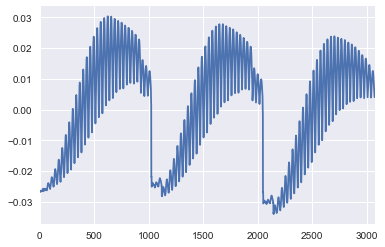

In [261]:
pd.Series(pca.components_[0]).plot()

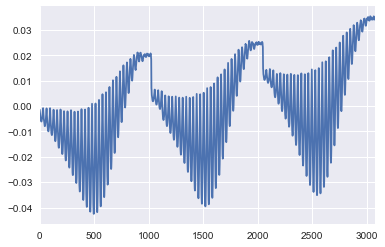

In [296]:
pd.Series(pca.components_[1]).plot()

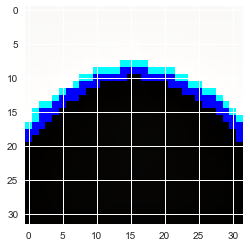

In [16]:
plt.imshow(pca.components_[0].reshape((3,1024)).swapaxes(0,1).reshape((32,32,3)))

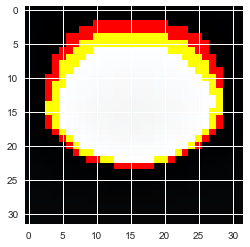

In [17]:
plt.imshow(pca.components_[1].reshape((3,1024)).swapaxes(0,1).reshape((32,32,3)))